In [1]:
#run ISSPxVTS_v5_step1_gatherData.py

In [2]:
from copy import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
from scipy import stats
from scipy.stats import norm
%matplotlib inline

### 1. Load in the summarized subject data

A total of 52 subjects


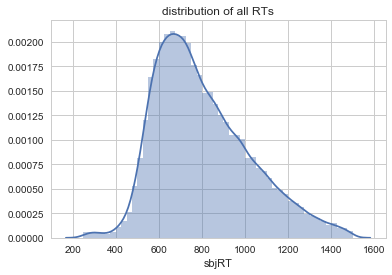

In [3]:
df = pd.read_pickle('gpData.pkl')
NrSbj = len(df.sbjId.unique())
#sns.distplot(df.loc[~np.isnan(df.sbjRT),'sbjRT'])
print('A total of ' + str(NrSbj) + ' subjects')
df.loc[df.sbjRT<250, 'sbjRT']  = np.nan
df.loc[df.sbjRT<250, 'sbjACC'] = 0
df.loc[df.sbjRT>1500, 'sbjRT']  = np.nan
df.loc[df.sbjRT>1500, 'sbjACC'] = 0
# stimulus duration was set to be 1500 ms. subj must respond within this deadline
sns.distplot(df.loc[~np.isnan(df.sbjRT),'sbjRT'])
plt.title('distribution of all RTs')

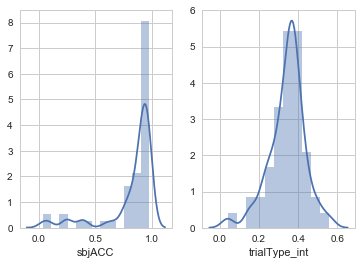

In [4]:
fig, ax = plt.subplots(1,2)
sns.distplot(df.loc[df.phase=="training"].groupby(['sbjId']).sbjACC.mean(), ax=ax[0])
sns.distplot(df.loc[df.trialType=='choice'].groupby(['sbjId']).trialType_int.mean().dropna(), ax=ax[1])

#### 1a. Exclude subjects with low task-switching accuracy (<=70%) during the training phase & overall VTS rate <= 5%

In [5]:
#%% do a fist pass to exclude subjects with low cued task accuracy
goodSbj=[]
excludeSbj=[]
for S in np.unique(df.sbjId):
    D = df.loc[df.sbjId==S] 
    overallCuedTSACC = D[D.trialType=='cued'].sbjACC.mean()*100
    trainingTSACC = D[D.phase=='training'].sbjACC.mean()*100
    overallVTS = D[D.trialType=='choice'].trialType_int.mean()*100
    if  (overallCuedTSACC >= 80) & ( trainingTSACC >= 0) & (overallVTS >= 10):  # & (D.sbjACC.mean()*100>60):
        goodSbj.append(S)
    else:
        excludeSbj.append(S)
df_valid = pd.DataFrame(np.empty((0,0),dtype=int))
for S in goodSbj:
    df_valid = pd.concat([df_valid, df[df.sbjId==S]],axis=0)
df_valid.reset_index(inplace=True)
validSCNT = len(df_valid.sbjId.unique())
print('After excluding subjects with poor performance: A total of ' + str(validSCNT) + ' subjects')

After excluding subjects with poor performance: A total of 38 subjects


### 2. Look at "cued" Task-switching data

Overall accuracy for the cued task-switching during training was 91.76%
Overall RT (correct trials) for the cued task-switching during training was 811.40ms


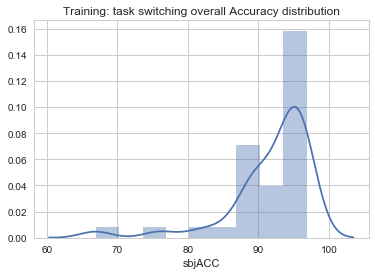

In [6]:
df_tskSw = df_valid.loc[df_valid.phase=='training',:].reset_index() 
sbj_tsACC = df_tskSw.groupby('sbjId').sbjACC.mean().reset_index()
# a dataframe of subject x mean_sbjACC
sns.distplot(sbj_tsACC.sbjACC*100)
plt.title('Training: task switching overall Accuracy distribution')
CTS_meanACC = df_tskSw.groupby('sbjId').sbjACC.mean().mean()*100
CTS_meanRT  = df_tskSw.loc[df_tskSw.sbjACC==1,:].groupby('sbjId').sbjRT.mean().mean()
print('Overall accuracy for the cued task-switching during training was ' + '{:.2f}'.format(CTS_meanACC) + '%')
print('Overall RT (correct trials) for the cued task-switching during training was ' + '{:.2f}'.format(CTS_meanRT) + 'ms')

### 2a. Cued Task-switching ACC as a function of 2 (blockType: training, hybrid) x 2 (swProb: 25%, 75%) x 2 (Trial Type: switch, repeat)

------Group mean ACC--------
phase     swProb  trialType_sw
training  sw25%   repeat          92.755631
                  switch          91.311191
          sw75%   repeat          92.131791
                  switch          90.795631
hybrid    sw25%   repeat          92.812108
                  switch          90.201542
          sw75%   repeat          92.700252
                  switch          90.909028
Name: sbjACC, dtype: float64


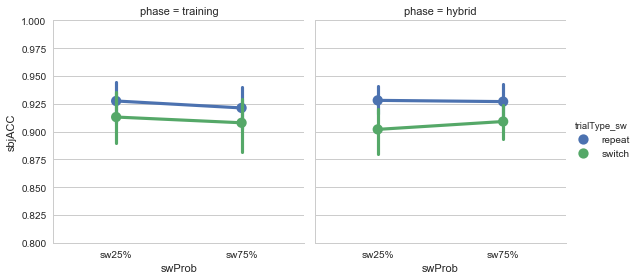

In [7]:
df_cued = df_valid.loc[df_valid.trialType=='cued',:].reset_index()
condM_acc = df_cued.groupby(['sbjId','phase','swProb','trialType_sw']).sbjACC.mean().reset_index()
# a dataframe of subject x condition 
g= sns.factorplot(x='swProb',y='sbjACC', hue='trialType_sw',col='phase', data=condM_acc)
g.set(ylim=(0.8, 1))

# Group Mean
gpResult_ts_acc  = condM_acc.groupby(['phase','swProb','trialType_sw']).sbjACC.mean()*100
print('------Group mean ACC--------')
print(gpResult_ts_acc)

meanISSP_ACC = -0.00 %
0.495836108478


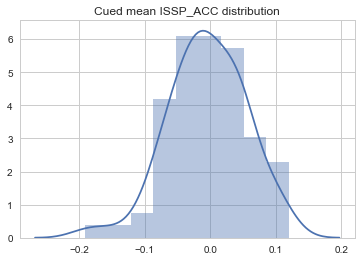

In [8]:
acc1 = np.array(condM_acc.loc[(condM_acc.swProb=='sw25%') & (condM_acc.trialType_sw=='switch'),'sbjACC'])
acc2 = np.array(condM_acc.loc[(condM_acc.swProb=='sw25%') & (condM_acc.trialType_sw=='repeat'),'sbjACC'])
acc3 = np.array(condM_acc.loc[(condM_acc.swProb=='sw75%') & (condM_acc.trialType_sw=='switch'),'sbjACC'])
acc4 = np.array(condM_acc.loc[(condM_acc.swProb=='sw75%') & (condM_acc.trialType_sw=='repeat'),'sbjACC'])
ISSP_acc = acc1-acc2-(acc3-acc4)
print('meanISSP_ACC = ' + '{:.2f}'.format(ISSP_acc.mean()) + ' %')
sns.distplot(ISSP_acc)
plt.title("Cued mean ISSP_ACC distribution")
simple_inX_test = stats.ttest_rel(acc1-acc2,acc3-acc4)
print(simple_inX_test.pvalue)

### 2b. Cued task-switching RT (correct trials) as a function of 2(blockType: training, hybrid) x 2 (swProb: 25%, 75%) x 2 (Trial Type: switch, repeat)

------Group mean ACC--------
phase     swProb  trialType_sw
training  sw25%   repeat          775.031828
                  switch          862.032867
          sw75%   repeat          787.868160
                  switch          840.036346
hybrid    sw25%   repeat          770.908200
                  switch          830.459001
          sw75%   repeat          773.733606
                  switch          825.869184
Name: sbjRT, dtype: float64


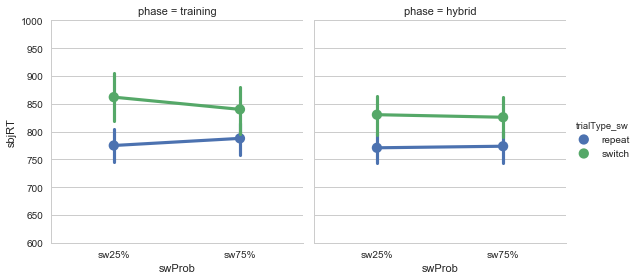

In [9]:
df_cued = df_valid.loc[df_valid.trialType=='cued',:].reset_index()
condM_rt = df_cued.loc[df_cued.sbjACC==1,:].groupby(['sbjId','phase','swProb','trialType_sw']).sbjRT.mean().reset_index()
# a dataframe of subject x condition 
g= sns.factorplot(x='swProb',y='sbjRT', hue='trialType_sw',col='phase', data=condM_rt)
g.set(ylim=(600, 1000))
# Group Mean
gpResult_ts_rt  = condM_rt.groupby(['phase','swProb','trialType_sw']).sbjRT.mean()
print('------Group mean ACC--------')
print(gpResult_ts_rt)

##### ISSP for the cued trials during both the training phase and the hybrid phase

meanISSP = 14.21 ms
0.012560326219


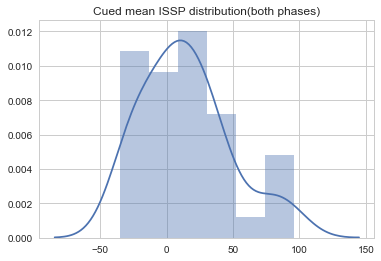

In [10]:
condM_rt = df_cued.loc[df_cued.sbjACC==1,:].groupby(['sbjId','swProb','trialType_sw']).sbjRT.mean().reset_index()
rt1 = np.array(condM_rt.loc[(condM_rt.swProb=='sw25%') & (condM_rt.trialType_sw=='switch'),'sbjRT'])
rt2 = np.array(condM_rt.loc[(condM_rt.swProb=='sw25%') & (condM_rt.trialType_sw=='repeat'),'sbjRT'])
rt3 = np.array(condM_rt.loc[(condM_rt.swProb=='sw75%') & (condM_rt.trialType_sw=='switch'),'sbjRT'])
rt4 = np.array(condM_rt.loc[(condM_rt.swProb=='sw75%') & (condM_rt.trialType_sw=='repeat'),'sbjRT'])
ISSP = rt1-rt2-(rt3-rt4)
print('meanISSP = ' + '{:.2f}'.format(ISSP.mean()) + ' ms')
sns.distplot(ISSP)
plt.title("Cued mean ISSP distribution(both phases)")
simple_inX_test = stats.ttest_rel(rt1-rt2,rt3-rt4)
print(simple_inX_test.pvalue)

In [11]:
ISSPxVTSdf = pd.DataFrame()
ISSPxVTSdf['sbjId']=condM_rt.sbjId.unique()
ISSPxVTSdf['ISSP_both'] = ISSP

meanISSP = 34.83 ms
0.00117343726934


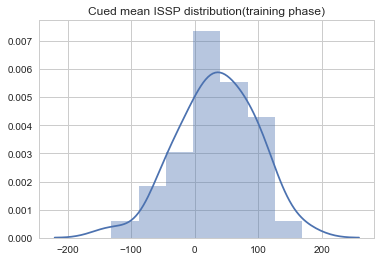

In [12]:
# ISSP just for the training phase
condM_rt = df_cued.loc[(df_cued.sbjACC==1) & (df_cued.phase=='training'),:].groupby(['sbjId','swProb','trialType_sw']).sbjRT.mean().reset_index()
rt1 = np.array(condM_rt.loc[(condM_rt.swProb=='sw25%') & (condM_rt.trialType_sw=='switch'),'sbjRT'])
rt2 = np.array(condM_rt.loc[(condM_rt.swProb=='sw25%') & (condM_rt.trialType_sw=='repeat'),'sbjRT'])
rt3 = np.array(condM_rt.loc[(condM_rt.swProb=='sw75%') & (condM_rt.trialType_sw=='switch'),'sbjRT'])
rt4 = np.array(condM_rt.loc[(condM_rt.swProb=='sw75%') & (condM_rt.trialType_sw=='repeat'),'sbjRT'])
ISSP = rt1-rt2-(rt3-rt4)
print('meanISSP = ' + '{:.2f}'.format(ISSP.mean()) + ' ms')
sns.distplot(ISSP)
plt.title("Cued mean ISSP distribution(training phase)")
simple_inX_test = stats.ttest_rel(rt1-rt2,rt3-rt4)
print(simple_inX_test.pvalue)

In [13]:
ISSPxVTSdf['ISSP_train'] = ISSP

meanISSP = 7.42 ms
0.252944945198


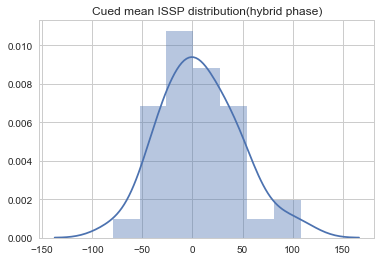

In [14]:
# ISSP just for the hybrid phase
condM_rt = df_cued.loc[(df_cued.sbjACC==1) & (df_cued.phase=='hybrid'),:].groupby(['sbjId','swProb','trialType_sw']).sbjRT.mean().reset_index()
rt1 = np.array(condM_rt.loc[(condM_rt.swProb=='sw25%') & (condM_rt.trialType_sw=='switch'),'sbjRT'])
rt2 = np.array(condM_rt.loc[(condM_rt.swProb=='sw25%') & (condM_rt.trialType_sw=='repeat'),'sbjRT'])
rt3 = np.array(condM_rt.loc[(condM_rt.swProb=='sw75%') & (condM_rt.trialType_sw=='switch'),'sbjRT'])
rt4 = np.array(condM_rt.loc[(condM_rt.swProb=='sw75%') & (condM_rt.trialType_sw=='repeat'),'sbjRT'])
ISSP = rt1-rt2-(rt3-rt4)
print('meanISSP = ' + '{:.2f}'.format(ISSP.mean()) + ' ms')
sns.distplot(ISSP)
plt.title("Cued mean ISSP distribution(hybrid phase)")
simple_inX_test = stats.ttest_rel(rt1-rt2,rt3-rt4)
print(simple_inX_test.pvalue)

In [15]:
ISSPxVTSdf['ISSP_hybrid_cued'] = ISSP

### 3. Look at Choice Task-switching data during hybrid phase

------Group mean ACC--------
swProb  trialType_sw
sw25%   repeat          96.533246
        switch          96.522728
sw75%   repeat          96.973142
        switch          96.375989
Name: sbjACC, dtype: float64


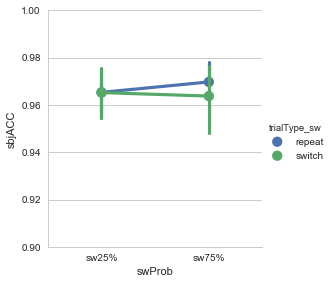

In [16]:
df_choice = df_valid.loc[df_valid.trialType=='choice',:].reset_index()
condM_acc = df_choice.groupby(['sbjId','swProb','trialType_sw']).sbjACC.mean().reset_index()  
# a dataframe of subject x condition 
g = sns.factorplot(x='swProb',y='sbjACC', hue='trialType_sw', data=condM_acc)
g.set(ylim=(.9, 1))
gpResult_choice_acc = condM_acc.groupby(['swProb','trialType_sw']).sbjACC.mean()*100
print('------Group mean ACC--------')
print(gpResult_choice_acc)

------Group mean RT--------
swProb  trialType_sw
sw25%   repeat          723.859833
        switch          768.806243
sw75%   repeat          730.621258
        switch          769.755176
Name: sbjRT, dtype: float64


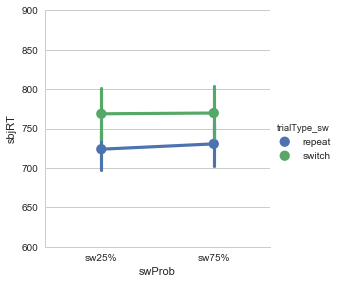

In [17]:
condM_rt = df_choice.loc[df_choice.sbjACC==1,:].groupby(['sbjId','swProb','trialType_sw']).sbjRT.mean().reset_index()  
# a dataframe of subject x condition 
g = sns.factorplot(x='swProb',y='sbjRT', hue='trialType_sw', data=condM_rt)
g.set(ylim=(600, 900))
gpResult_choice_rt = condM_rt.groupby(['swProb','trialType_sw']).sbjRT.mean()
print('------Group mean RT--------')
print(gpResult_choice_rt)

meanISSP_choice = 7.42 ms
0.507928534481


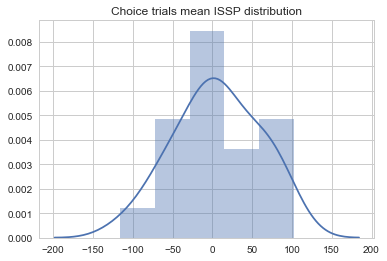

In [18]:
rt1 = np.array(condM_rt.loc[(condM_rt.swProb=='sw25%') & (condM_rt.trialType_sw=='switch'),'sbjRT'])
rt2 = np.array(condM_rt.loc[(condM_rt.swProb=='sw25%') & (condM_rt.trialType_sw=='repeat'),'sbjRT'])
rt3 = np.array(condM_rt.loc[(condM_rt.swProb=='sw75%') & (condM_rt.trialType_sw=='switch'),'sbjRT'])
rt4 = np.array(condM_rt.loc[(condM_rt.swProb=='sw75%') & (condM_rt.trialType_sw=='repeat'),'sbjRT'])
ISSP_choice = rt1-rt2-(rt3-rt4)
print('meanISSP_choice = ' + '{:.2f}'.format(ISSP.mean()) + ' ms')
sns.distplot(ISSP_choice)
plt.title("Choice trials mean ISSP distribution")
simple_inX_test = stats.ttest_rel(rt1-rt2,rt3-rt4)
print(simple_inX_test.pvalue)
ISSPxVTSdf['ISSP_hybrid_choice'] = ISSP_choice

### 4. Choice trials, VSR as a function of 25% vs. 75% switch items

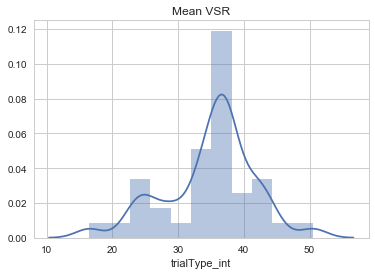

In [19]:
df_choice = df_valid.loc[(df_valid.trialType=='choice'),:].reset_index() 
meanVTS  = df_choice.groupby(['sbjId']).trialType_int.mean()
g = sns.distplot(meanVTS*100)
plt.title("Mean VSR")
ISSPxVTSdf['VSR']= np.array(meanVTS)

swProb
sw25%    34.164468
sw75%    35.606241
Name: trialType_int, dtype: float64
0.118729383581


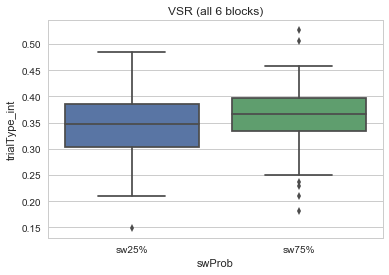

In [20]:
vts_rate = df_choice.groupby(['sbjId','swProb']).trialType_int.mean().reset_index()  
gp_vtsRate = vts_rate.groupby(['swProb']).trialType_int.mean()*100
print(gp_vtsRate)
g = sns.boxplot(x='swProb',y='trialType_int',data=vts_rate)
plt.title("VSR (all 6 blocks)")
vts_25 = np.array(vts_rate.loc[vts_rate.swProb=='sw25%','trialType_int'])
vts_75 = np.array(vts_rate.loc[vts_rate.swProb=='sw75%','trialType_int'])
vtsRate_t = stats.ttest_rel(vts_25,vts_75)
print(vtsRate_t.pvalue)
ISSPxVTSdf['VSR_diff']=(vts_75-vts_25)*100

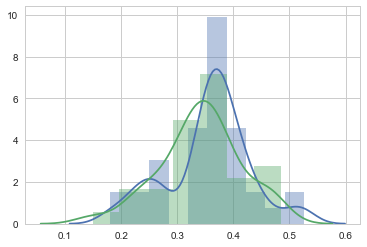

In [21]:
sns.distplot(vts_75)  # blue
sns.distplot(vts_25)  # green

swProb
sw25%    33.632513
sw75%    36.277952
Name: trialType_int, dtype: float64
0.0180899233653


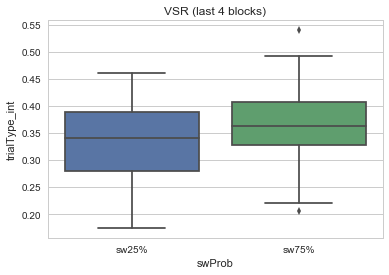

In [22]:
vts_rate_post = df_choice.loc[df_choice.runId>=5].groupby(['sbjId','swProb']).trialType_int.mean().reset_index()  
gp_vtsRate_post = vts_rate_post.groupby(['swProb']).trialType_int.mean()*100
print(gp_vtsRate_post)
g = sns.boxplot(x='swProb',y='trialType_int',data=vts_rate_post)
plt.title("VSR (last 4 blocks)")
vts_25 = np.array(vts_rate_post.loc[(vts_rate.swProb=='sw25%'),'trialType_int'])
vts_75 = np.array(vts_rate_post.loc[(vts_rate.swProb=='sw75%'),'trialType_int'])
vtsRate_t = stats.ttest_rel(vts_25,vts_75)
print(vtsRate_t.pvalue)
ISSPxVTSdf['VSR_diff2']=(vts_75-vts_25)*100

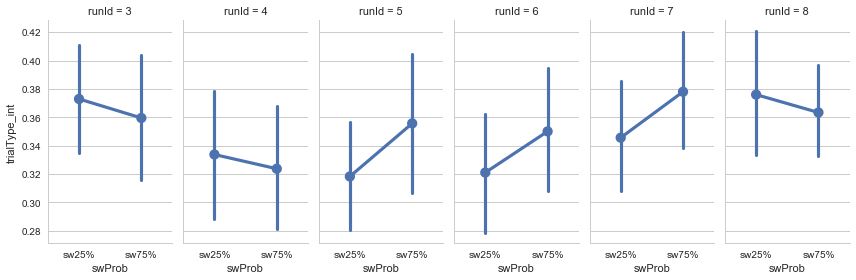

In [23]:
vts_rate_byRun = df_choice.groupby(['runId','sbjId','swProb']).trialType_int.mean().reset_index()
g = sns.factorplot(x='swProb',y='trialType_int',col= 'runId',data=vts_rate_byRun,aspect=.5)

In [24]:
ISSPxVTSdf.head(5)

,sbjId,ISSP_both,ISSP_train,ISSP_hybrid_cued,ISSP_hybrid_choice,VSR,VSR_diff,VSR_diff2
0,1.0,15.067369,-33.487515,37.270378,71.567652,0.164894,3.191489,3.174603
1,2.0,-12.746617,18.708949,-18.876310,12.202971,0.354167,-4.166667,-1.562500
2,3.0,-23.988850,-27.328071,-22.067966,-36.547479,0.405263,-8.222518,-2.923387
3,4.0,10.826188,26.161189,13.950572,-63.094725,0.413613,-9.857456,-1.562500
4,5.0,11.524229,16.969761,0.265536,-23.192939,0.359788,7.493280,9.733607


(0.28590829436719362, 0.081839223999918234)

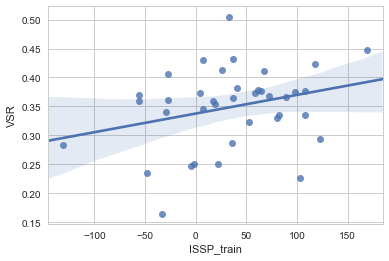

In [25]:
ax = sns.regplot(x="ISSP_train", y="VSR", data = ISSPxVTSdf, x_jitter=.1)
stats.pearsonr(ISSPxVTSdf.ISSP_train, ISSPxVTSdf.VSR)  # r, p

In [26]:
ISSPxVTSdf.ISSP_train.mean()

34.83285306432289

(0.2787770382106971, 0.090098895418904187)

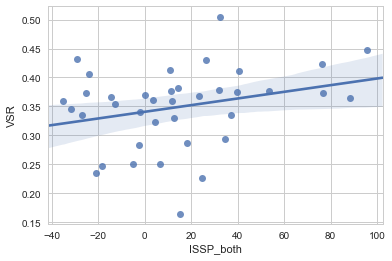

In [27]:
ax = sns.regplot(x="ISSP_both", y="VSR", data = ISSPxVTSdf, x_jitter=.1)
stats.pearsonr(ISSPxVTSdf.ISSP_both, ISSPxVTSdf.VSR)  # r, p

(0.03888466704480676, 0.81670773759286697)

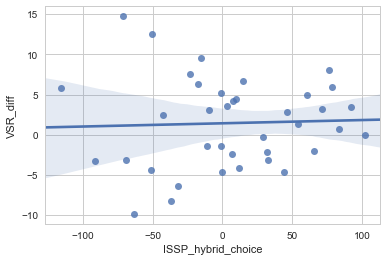

In [28]:
ax = sns.regplot(x="ISSP_hybrid_choice", y="VSR_diff", data = ISSPxVTSdf, x_jitter=.1)
stats.pearsonr(ISSPxVTSdf.ISSP_hybrid_choice, ISSPxVTSdf.VSR_diff)  # r, p

In [29]:
ISSPxVTSdf.ISSP_train.median()

36.103160705931316

38
19
swProb
sw25%    35.509816
sw75%    37.329433
Name: trialType_int, dtype: float64
0.185695728621


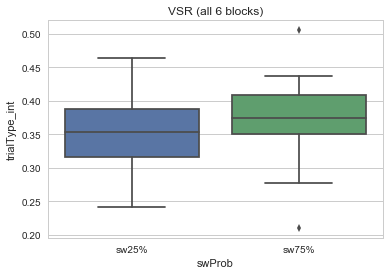

In [30]:
# spilt Half 
print(len(ISSPxVTSdf.sbjId.unique()))
tt=ISSPxVTSdf.loc[ISSPxVTSdf.ISSP_train >36,"sbjId"]
df_valid_half = pd.DataFrame(np.empty((0,0),dtype=int))
for S in tt:
    df_valid_half = pd.concat([df_valid_half, df[df.sbjId==S]],axis=0)
df_valid_half.reset_index(inplace=True)

NrS = len(df_valid_half.sbjId.unique())
print(NrS)

df_choice = df_valid_half.loc[df_valid_half.trialType=="choice",:]
vts_rate = df_choice.groupby(['sbjId','swProb']).trialType_int.mean().reset_index()  
gp_vtsRate = vts_rate.groupby(['swProb']).trialType_int.mean()*100
print(gp_vtsRate)
g = sns.boxplot(x='swProb',y='trialType_int',data=vts_rate)
plt.title("VSR (all 6 blocks)")
vts_25 = np.array(vts_rate.loc[vts_rate.swProb=='sw25%','trialType_int'])
vts_75 = np.array(vts_rate.loc[vts_rate.swProb=='sw75%','trialType_int'])
vtsRate_t = stats.ttest_rel(vts_25,vts_75)
print(vtsRate_t.pvalue)